# Embeddings - Use-case Examples

In this notebook you can find examples for use cases where the Embeddings endpoint might be useful for your needs.

### Imports

In [1]:
import requests
import pandas as pd
import random
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import wikipedia
from tqdm import tqdm
from itertools import islice
import plotly.express as px
import plotly.io as pio

In [2]:
# TODO: fill your API key from AI21 Studio account
API_KEY = ""
assert API_KEY != "", "You must provide an API key!"

### Functions
Wrapping the API call in an easy to use way

In [3]:
def create_embeddings(texts):
    """
        Create embeddings for a list of texts.
        
        Arguments:
        - texts       : list of texts. Each text is limited to 2,000 chars
                        and the number of elements should be <= 200

        Returns:
        - embeddings  : list of embeddings match to the input texts
    """
    
    resp = requests.post(
        "https://api.ai21.com/studio/v1/experimental/embed",
        headers={"Authorization": f"Bearer {API_KEY}"},
        json={
            "texts": texts
        }
    )
    
    if resp.status_code != 200:
        raise Exception(f"Completion request failed with status {resp.status_code}")

    embeddings = [x['embedding'] for x in resp.json()['results']]
    return embeddings


def chunkify(l, n):
    l = iter(l)
    while True:
        b = list(islice(l, n))
        if not b:
            return
        yield b

        
def run_multiple_embeddings(long_texts):
    """
        Create embeddings for a long list of texts. Use this if you have more than 200 elements to embed.
        
        Arguments:
        - texts       : list of texts. Each text is limited to 2,000 chars

        Returns:
        - embeddings  : list of embeddings match to the input texts
    """
    embeddings = []
    for texts in tqdm(chunkify(long_texts, 200)):
        embeddings.extend(create_embeddings(texts))

    return embeddings

## Semantic search on quotes

This is an example for a semantic search use-case.
We will embed a collection of famous quotes, then perform rewrite to one of them and search for the closest one in the collection (semantically).

Download famous quotes from [here](https://offers.hubspot.com/250-famous-quotes?hubs_post-cta=anchor&hsCtaTracking=218f0385-73f5-48f1-9731-306238cbf450%7C0e4e41cc-7da8-4e7f-9156-e09c48f2603b).

In [4]:
quotes_df = pd.read_csv("Quotes.csv")

In [5]:
quotes_df

,Quote,Person
0,The way to get started is to quit talking and ...,Walt Disney
1,"Your time is limited, so don't waste it living...",Steve Jobs
2,If life were predictable it would cease to be ...,Eleanor Roosevelt
3,"If you look at what you have in life, you'll a...",Oprah Winfrey
4,If you set your goals ridiculously high and it...,James Cameron
...,...,...
96,I would rather die of passion than of boredom.,Vincent van Gogh
97,"Dreaming, after all, is a form of planning.",Gloria Steinem
98,Whatever the mind of man can conceive and beli...,Napoleon Hill
99,"First, have a definite, clear practical ideal;...",Aristotle


In [6]:
# Embed all the collection of quotes
quotes = quotes_df['Quote'].tolist()
quotes_emd = create_embeddings(quotes)

#### Generate a query
This step comes to simulate a situation where you are looking for a quote by its' essence but not by phrasing.
- Choose a random quote
- Paraphrase it using the Rewrite API
- Choose a paraphrase which is similar by meaning but not in words

In [7]:
rand_ind = random.randint(0, len(quotes_emd))

rewrite_quote_json = requests.post(
        "https://api.ai21.com/studio/v1/experimental/rewrite",
        headers={"Authorization": f"Bearer {API_KEY}"},
        json={
            "text": quotes[rand_ind]
        }
)

re_quote = rewrite_quote_json.json()['suggestions'][8]['text']

In [8]:
print(f"Original quote by {quotes_df.iloc[rand_ind]['Person']}:")
print(quotes[rand_ind])
print("Paraphrased quote by Rewrite API:")
print(re_quote)

Original quote by Colin R. Davis:
The road to success and the road to failure are almost exactly the same.
Paraphrased quote by Rewrite API:
Roads to success and failure are almost identical.


#### Find the closest quote
using Cosine similarity

In [9]:
embed_re_quote = np.squeeze(create_embeddings([re_quote]))
print("Was the search successful?")
np.argmax(np.dot(quotes_emd, embed_re_quote)) == rand_ind

Was the search successful?


True

## Information retrieval

The following is an example of a retrieval use-case.

We will take a long text (in this example, the Wikipedia entry on "The Office"), divide it into slices (using our [Slice API](https://docs.ai21.com/docs/summarization-summarize#slice-api)) and embed every slice. Then, we can embed any given question (query) and find the slice that contains the answer.

In [10]:
# Get the content from Wikipedia
wiki_page = wikipedia.page("The_Office_(American_TV_series)").content

Slice the text using our [Slice API](https://docs.ai21.com/docs/summarization-summarize#slice-api):

In [11]:
slice_resp = requests.post(
    "https://api.ai21.com/studio/v1/experimental/slice",
    headers={"Authorization": f"Bearer {API_KEY}"},
    json={
        "text": wiki_page
    }
) 

office_text = [x['text'] for x in slice_resp.json()['slices']]

Create embeddings for every slice:

In [12]:
office_embds = create_embeddings(office_text)

In [13]:
question = "What was the second branch Jim worked"
question_embd = create_embeddings([question])

#### Find the closest slice
using Cosine similarity

In [14]:
print(office_text[np.argmax(np.dot(office_embds, np.squeeze(question_embd)))])

=== Season 2 === The second season is the series' first 22-episode season and has its first 28-minute "super-sized" episode.

Many workers seen in the background of the first season are developed into secondary characters and romantic relationships begin to develop between some of them.

Michael makes out with and then spends the night with his boss, Jan Levinson, but does not have sex with her.

Dwight and Angela become romantically involved, but keep their relationship a secret.

Kelly Kapoor develops a crush on Ryan, and they start dating off and on.

When Roy finally agrees to set a date for his wedding to Pam, at a company booze cruise, Jim grows depressed and considers transferring to the Stamford, Connecticut branch, but tells Pam in the season finale that he is in love with her.

Even though Pam insists she is with Roy, the two kiss, and Jim transfers to the Stamford branch soon after.

The general threat of downsizing continues throughout the season as well.


## Clustering

The following is an example of a clustering use-case.

The goal is to take a group of texts and cluster them based on their similarity (similar to classification, but without labels).

As a way of testing our results, we will use a classification dataset called "AG news" (you can find it [here](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)). It contains articles that are classified based on their title and their summary into one of four categories: “World”, “Sports”, “Business” or “Science and Technology”.

In [15]:
agnews_df = pd.read_csv("agnews_test.csv")

In [16]:
news_list = agnews_df['Description'].tolist()
news_embeds = run_multiple_embeddings(news_list)

38it [02:42,  4.28s/it]


### Perform the clustering on the embedded news articles
Using K-Means clustering

In [17]:
result = KMeans(n_clusters=4).fit_predict(news_embeds)

/Users/yuvalbelfer/.pyenv/versions/3.9.6/envs/jupyter-env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Dimensionality reduction
Lower the dimension of the embeddings so we can visualize it

Using t-SNE

In [18]:
news_tsne = TSNE(n_components=3).fit_transform(np.array(news_embeds))

In [19]:
agnews_df['x'] = news_tsne[:,0]
agnews_df['y'] = news_tsne[:,1]
agnews_df['z'] = news_tsne[:,2]

In [20]:
# Consists of class ids 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech
class_dict = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
agnews_df['Class'] = agnews_df['Class Index'].apply(lambda x: class_dict[x])
# agnews_df.rename(columns={'Class Index': 'Class'}, inplace=True)

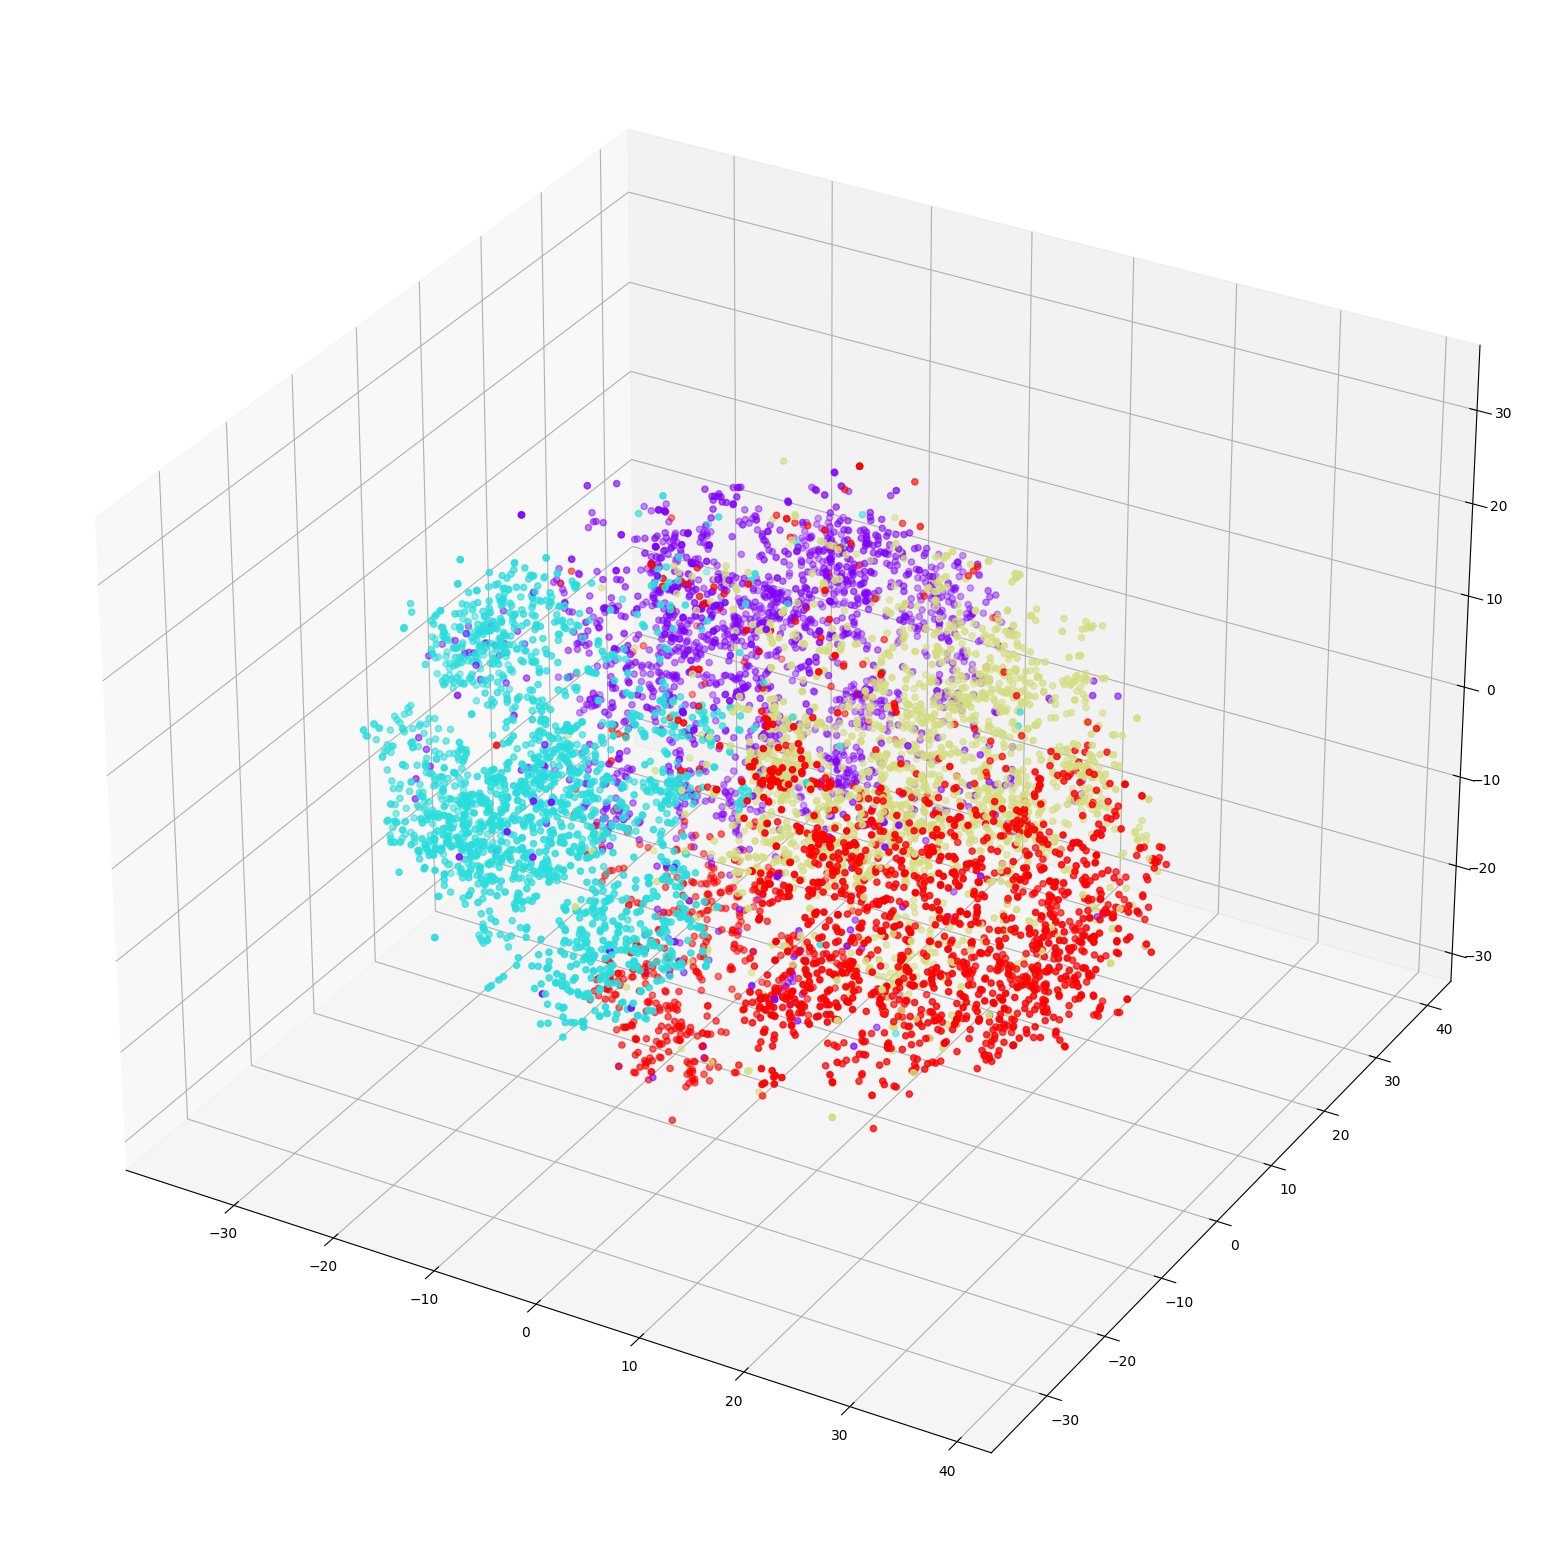

In [21]:
plt.figure(figsize=(30,20))
ax = plt.axes(projection ="3d")
ax.scatter3D(agnews_df['x'], agnews_df['y'], agnews_df['z'], c=agnews_df["Class Index"].values, cmap='rainbow')

#### Get an interactive version of this graph by running the cell
Alternatively, you can render this notebook through [here](https://nbviewer.org/)

In [1]:
fig = px.scatter_3d(agnews_df, x='x', y='y', z='z', color='Class')
fig.show("notebook")
pio.renderers.default='notebook'

NameError: name 'px' is not defined